# DistilBERT Intent Classifier
Fine-tune a DistilBERT model using HuggingFace Transformers for intent classification.

In [1]:
import pandas as pd
import numpy as np
import time
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import os

start_time = time.time()

# Load and encode data
df = pd.read_csv("final_combined_grouped_dataset.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


C:\Users\Anirudh\anaconda3\envs\chat_nlp\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\Anirudh\anaconda3\envs\chat_nlp\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\Anirudh\anaconda3\envs\chat_nlp\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

train_dataset = HFDataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train.tolist()
})

test_dataset = HFDataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test.tolist()
})


C:\Users\Anirudh\anaconda3\envs\chat_nlp\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# Model setup
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="C:/Users/Anirudh/Desktop/nlp_project/checkpoints/results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="C:/Users/Anirudh/Desktop/nlp_project/checkpoints/logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.196600,0.130776
2,0.016700,0.014322
3,0.010400,0.010190


Checkpoint destination directory C:/Users/Anirudh/Desktop/nlp_project/checkpoints/results\checkpoint-114 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory C:/Users/Anirudh/Desktop/nlp_project/checkpoints/results\checkpoint-228 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory C:/Users/Anirudh/Desktop/nlp_project/checkpoints/results\checkpoint-342 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=342, training_loss=0.362344801033798, metrics={'train_runtime': 38.1144, 'train_samples_per_second': 71.784, 'train_steps_per_second': 8.973, 'total_flos': 13451019694848.0, 'train_loss': 0.362344801033798, 'epoch': 3.0})

                            precision    recall  f1-score   support

              check_return       1.00      1.00      1.00        34
             find_by_email       1.00      1.00      1.00        25
find_by_email+check_return       1.00      1.00      1.00        30
find_by_email+return_order       1.00      1.00      1.00        40
              return_order       1.00      1.00      1.00        24
               track_order       1.00      1.00      1.00        26
  track_order+check_return       1.00      1.00      1.00        27
  track_order+return_order       1.00      1.00      1.00        23

                  accuracy                           1.00       229
                 macro avg       1.00      1.00      1.00       229
              weighted avg       1.00      1.00      1.00       229



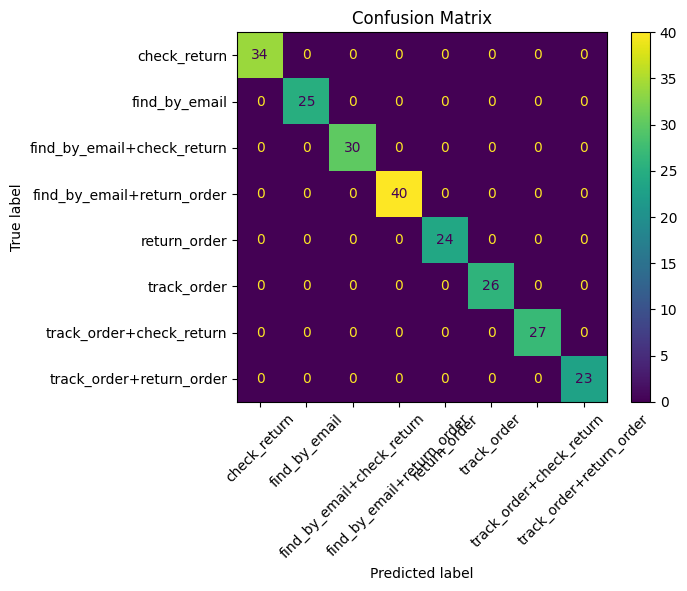

In [4]:
# Predictions and evaluation
preds = trainer.predict(test_dataset).predictions
y_pred = np.argmax(preds, axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [5]:
# Save best model and label encoder
os.makedirs("C:/Users/Anirudh/Desktop/nlp_project/checkpointss/bert", exist_ok=True)
model.save_pretrained("C:/Users/Anirudh/Desktop/nlp_project/checkpointss/bert")
tokenizer.save_pretrained("C:/Users/Anirudh/Desktop/nlp_project/checkpointss/bert")
import joblib
joblib.dump(label_encoder, "C:/Users/Anirudh/Desktop/nlp_project/checkpointss/bert/label_encoder.pkl")
print("Model and tokenizer saved.")


Model and tokenizer saved.


In [6]:
import pickle

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

# Save it properly
with open("intent_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [7]:
# Runtime logging
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")


Training completed in 42.91 seconds


In [8]:
# Predict on custom input
def predict_intent(text):
    model.eval()
    encoded = torch.tensor(encode(text), dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(encoded)
        pred = torch.argmax(output, dim=1).item()
    return label_encoder.inverse_transform([pred])[0]

# Example
predict_intent(" pls,return order")

NameError: name 'encode' is not defined